#  Completeness and Purity - DC2 with RedMaPPer - NumCosmo

---
**License**

 Completeness and Purity - DC2 with RedMaPPer - NumCosmo

 Mon Jan 13 14:30:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---
 completeness_purity\
 Copyright (C) 2025 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [1]:
import sys

import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd

sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/MachingCatalogs")

import GCRCatalogs
#Put nersc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

# GCRCatalogs.get_available_catalog_names()

GCRCatalogs = 1.9.0 | GCR = 0.9.2


In [2]:
import clevar
from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
from clevar.match import output_matched_catalog
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf


## Catalogs

In [3]:
# #Cosmo DC2
# cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

# #Cosmo DC2 + RedMaPPer
# catalog_dc2_redmapper = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')

In [4]:
# # Restrictions on richness, mass and redshift
# min_richness = 0
# min_halo_mass = 1e13 #Msunmmm
# redshift_max pd.merge(all_combinations, ..., how='inner'): Ele pega um DataFrame de entrada (presumivelmente all_combinations, que deve conter todas as informações originais sobre os pares) e o filtra, mantendo apenas as linhas que correspondem aos pares ('cat1_id', 'cat2_id') selecionados pelo algoritmo de max_weight_matching.

# #cDC2 + RM data
# quantities = catalog_dc2_redmapper.list_all_quantities()
# cluster_quantities = [q for q in quantities if 'member' not in q]
# member_quantities = [q for q in quantities if 'member' in q]
    
# query = GCRCatalogs.GCRQuery('(richness > ' + str(min_richness) +')')
# cluster_data = Table(catalog_dc2_redmapper.get_quantities(cluster_quantities, [query])) # cDC2 + RM cluster data
# member_data = Table(catalog_dc2_redmapper.get_quantities(member_quantities)) # cDC2 + RM member data

# #cDC2 data
# quantities_wanted = ['redshift','halo_mass','halo_id','galaxy_id','ra','dec', 'is_central']
# query = GCRCatalogs.GCRQuery('(halo_mass > ' + str(min_halo_mass) +') & (redshift < ' + str(redshift_max) +') & (is_central < ' + str(redshift_max) +') ')
# truth_data = Table(cosmodc2.get_quantities(quantities_wanted, [query]))

cluster_data = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cluster_data.fits')
member_data = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/member_data.fits')
truth_data = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/truth_data.fits')

In [5]:
# cluster_data

In [15]:
truthdf = truth_data.to_pandas().rename(columns={'galaxy_id': 'id'})

halo_g = truthdf.groupby('halo_id')

halo_data = pd.DataFrame(data = {'halo_id':[], 'halo_mass': [], 'halo_redshift': []})
                                 
for ha in truthdf['halo_id'].unique():
    halo_mass =  halo_g.get_group(ha)['halo_mass'].iloc[0]
    halo_redshift = np.mean(halo_g.get_group(ha)[['redshift']])

    data = pd.DataFrame([{'halo_id': ha, 'halo_mass': halo_mass, 'halo_redshift': halo_redshift}])                
    
    halo_data = pd.concat([halo_data, data], ignore_index=True)

In [7]:
mdata = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/match_proximity.fits')


In [8]:
test_matchdata = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/match_ID.fits')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["cat1_redshift"]
mass_data = test_matchdata["halo_mass"]

mt_data2 = Table([mass_data, rich_data, z_data], names=('mass', 'R', 'z'))

In [9]:
# CLEVAR

min_richness = 5
min_halo_mass = 1e13 #Msun

# Halos/Clusters
#CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
RM_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/RM_cat.fits', name='RM_cat', full=True) #tags={'mass':'richness'}

#CosmoDC2: 'cosmoDC2_v1.1.4_image'
halo_cat = ClCatalog.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/halo_cat.fits', name='halo_cat', full=True) #tags={'mass':'mass_fof'}

#Members
RM_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/RM_cat_members.fits',  full=True)
halo_cat.read_members('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/halo_cat_members.fits', full=True)

#Match catalogs
mt = MembershipMatch()

mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/cDC2_RM_match_cross_membership/')
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'self')

RM_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    45,081
 * multiple (self):  43,106
 * multiple (other): 43,106
 * unique (self):    42,914
 * unique (other):   42,917
 * cross:            42,914

halo_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    249,557
 * multiple (self):  74,474
 * multiple (other): 74,474
 * unique (self):    42,917
 * unique (other):   42,914
 * cross:            42,914


In [10]:
mt_data3 = Table([RM_cat_bij['id'], halo_cat_bij['id'],halo_cat_bij['mass'], RM_cat_bij['mass'], RM_cat_bij['z']], names=('cluster_id', 'halo_id','mass', 'R', 'z'))
# dt_halos = clusters_dt[np.logical_and(clusters_dt['redshift_true'] > 0.14, clusters_dt['redshift_true']< 0.33)]
# dt_halos = dt_halos[dt_halos['richness'] > 20]
# dt_halos = clusters_dt

# mt_data3 = Table([halo_cat_bij['mass_fof'], halo_cat_bij['z'], halo_cat_bij['ra'], halo_cat_bij['dec'],
#                   RM_cat_bij['richness'], RM_cat_bij['richness_err'], RM_cat_bij['z'], RM_cat_bij['ra'], RM_cat_bij['dec']], 
#                  names=('halo_mass', 'redshift', 'ra', 'dec', 'richness', 'richness_err', 'cluster_redshift', 'cluster_ra', 'cluster_dec'))

mt_data3 = mt_data3.to_pandas()


## Completeness

The **completeness** ($c(M, z)$) of a cluster catalog is defined as the fraction of true galaxy clusters correctly identified by the algorithm within a specific mass range ($M$)  and redshift ($z$). It is calculated as follows ([Aguena, Lima 2016](
https://doi.org/10.48550/arXiv.1611.05468
)):

$$
c(M, z) = \frac{N_{\text{mat}}(M, z)}{N_h(M, z)}
$$

Where:  
$N_{\text{mat}}(M, z)$ : Number of halos with mass ($M$) and redshift ($z$) that were correctly matched to clusters detected in the catalog.  
$N_h(M, z)$: Total number of halos with mass ($M$) and redshift ($z$) present in the dataset.

In [11]:
def completeness(halos, clusters, bin_range = None, bins = None) :

    hist_matches = np.histogram2d(clusters['z'], np.log10(clusters['mass']),range=bin_range, bins= bins)
    N_matches = hist_matches[0]
    # print(N_matches)
    
    hist_halos = np.histogram2d(halos["halo_redshift"],np.log10(halos['halo_mass']),range=bin_range, bins= bins)
    N_halos = hist_halos[0]
    # print(N_halos)
    
    complet =  N_matches / N_halos 
           
    return complet


In [13]:
# bin_range = [[0.0,1.2],[13.,16]]
# bins = [8,6]

# complet = completeness(halo_data, mdata, bin_range = bin_range, bins = bins) 

# fig, ax = plt.subplots(1,1)

# hist2d = ax.imshow(complet.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
#                                                                   bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
# fig.colorbar(hist2d , ax=ax)

# ax.set_xlabel('$z$')
# ax.set_ylabel('$log(M)$')

# ax.set_title('completeness (proximity)')

# plt.show()

/tmp/ipykernel_811785/3195316643.py:11: RuntimeWarning: invalid value encountered in divide
  complet =  N_matches / N_halos


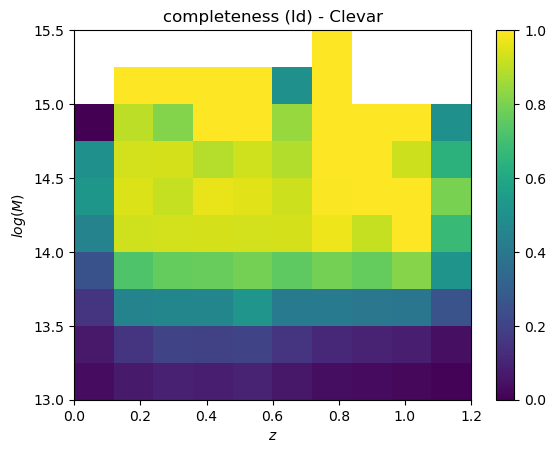

In [39]:
bin_range = [[0.0,1.2],[13.,15.5]]
bins = [10,10]

complet_clevar = completeness(halo_data, mt_data3, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d_clevar = ax.imshow(complet_clevar.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d_clevar , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(M)$')

ax.set_title('completeness (Id) - Clevar')

plt.show()

/tmp/ipykernel_811785/3195316643.py:11: RuntimeWarning: invalid value encountered in divide
  complet =  N_matches / N_halos


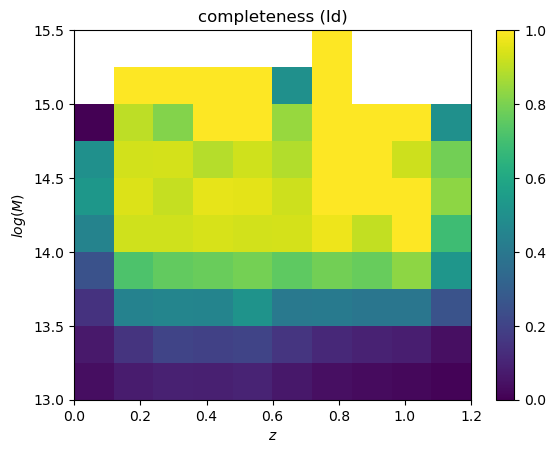

In [40]:
complet_id = completeness(halo_data, mt_data2, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d_id = ax.imshow(complet_id.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d_id , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(M)$')

ax.set_title('completeness (Id)')

plt.show()

## Purity

**Purity** ( $ p(\lambda, z)$ ) measures the fraction of detected clusters that correspond to true halos, serving as a metric to avoid false positives in the catalog. It is calculated as ([Aguena, Lima 2016](
https://doi.org/10.48550/arXiv.1611.05468
)):

$$
p(M, z) = \frac{N_{\text{mat}}(\lambda, z)}{N_c(\lambda, z)}
$$

Where:  
$ N_{\text{mat}}(\lambda, z)$: Number of detected clusters that are correctly matched to true dark matter halos.  
$ N_c(\lambda, z) $: Total number of clusters detected by the algorithm within an observed richness range $\lambda$ and  redshift $z$.

In [38]:
def purity(catalog_clusters, clusters, bin_range = None, bins = None) :

    hist_matches = np.histogram2d(clusters['z'], np.log(clusters['R']),range=bin_range, bins= bins)
    N_matches = hist_matches[0]
    # print(N_matches)
    
    hist_c = np.histogram2d(catalog_clusters["cluster_redshift"],np.log(catalog_clusters['richness']),range=bin_range, bins= bins)
    N_c = hist_c[0]
    # print(N_c)
    
    purit =  N_matches / N_c 
           
    return purit


/tmp/ipykernel_811785/805087121.py:11: RuntimeWarning: invalid value encountered in divide
  purit =  N_matches / N_c


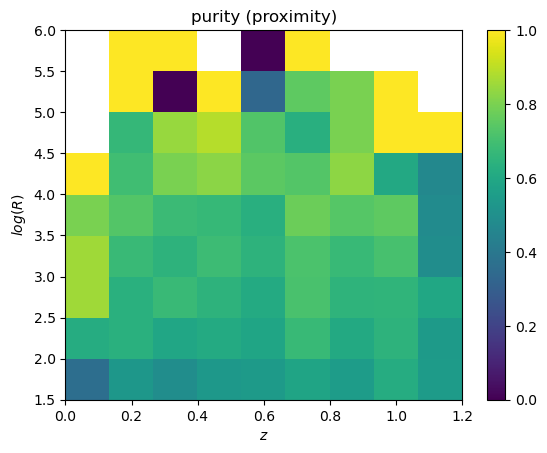

In [24]:
bin_range = [[0, 1.2],[1.5, 6.0]]
bins = [9,9]

pur = purity(cluster_data, mdata, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(pur.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(R)$')

ax.set_title('purity (proximity)')

plt.show()

/tmp/ipykernel_811785/805087121.py:11: RuntimeWarning: invalid value encountered in divide
  purit =  N_matches / N_c


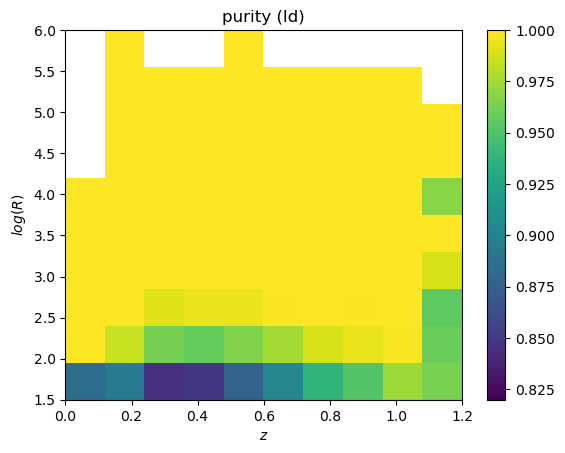

In [25]:
bin_range = [[0, 1.2],[1.5, 6.0]]
bins = [10,10]

pur = purity(cluster_data, mt_data2, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(pur.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0.82, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(R)$')

ax.set_title('purity (Id)')

plt.show()

/tmp/ipykernel_811785/805087121.py:11: RuntimeWarning: invalid value encountered in divide
  purit =  N_matches / N_c


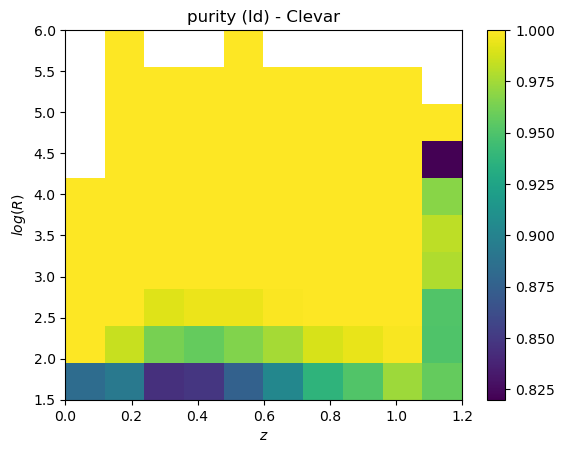

In [28]:
bin_range = [[0, 1.2],[1.5, 6.0]]
bins = [10,10]

from matplotlib.colors import LogNorm

pur = purity(cluster_data, mt_data3, bin_range = bin_range, bins = bins) 

fig, ax = plt.subplots(1,1)

hist2d = ax.imshow(pur.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1], 
                                                                  bin_range[1][0], bin_range[1][1]], vmin=0.82, vmax=1, cmap='viridis')
fig.colorbar(hist2d , ax=ax)

ax.set_xlabel('$z$')
ax.set_ylabel('$log(R)$')

ax.set_title('purity (Id) - Clevar')

plt.show()